In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 4.5703345390527765
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1086.38it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1107.40it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1044.91it/s]


In [6]:
from dataset import optDatasetConstrs
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 718.78it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 1e-2
num_epochs = 20
log_step = 2

In [11]:
import time
from tqdm import tqdm

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # get loss
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### Exact Method 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

(CVXPY) Dec 04 02:12:18 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 1


In [14]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  51.2836%, Val Regret:  52.8955%


Epoch    1, Loss:  -0.9997:  10%|█████▌                                                 | 2/20 [00:07<00:43,  2.40s/it]

Epoch   2, Train Regret:   5.6985%, Val Regret:   6.1739%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:11<00:35,  2.23s/it]

Epoch   4, Train Regret:   2.3633%, Val Regret:   2.4281%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:15<00:29,  2.14s/it]

Epoch   6, Train Regret:   1.7492%, Val Regret:   1.2477%


Epoch    7, Loss:  -0.9998:  40%|██████████████████████                                 | 8/20 [00:20<00:25,  2.09s/it]

Epoch   8, Train Regret:   1.4645%, Val Regret:   1.0061%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [00:24<00:20,  2.02s/it]

Epoch  10, Train Regret:   1.1800%, Val Regret:   0.7217%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [00:28<00:15,  1.97s/it]

Epoch  12, Train Regret:   1.1008%, Val Regret:   0.6517%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [00:32<00:11,  1.99s/it]

Epoch  14, Train Regret:   0.9924%, Val Regret:   0.9228%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [00:36<00:07,  1.99s/it]

Epoch  16, Train Regret:   1.1979%, Val Regret:   0.9018%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [00:41<00:03,  1.98s/it]

Epoch  18, Train Regret:   1.1939%, Val Regret:   1.0840%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.19s/it]


Epoch  19, Train Regret:   1.0740%, Val Regret:   1.1937%

Evaluation:
Test Regret: 0.9212%
Training Elapsed Time: 8.49 Sec


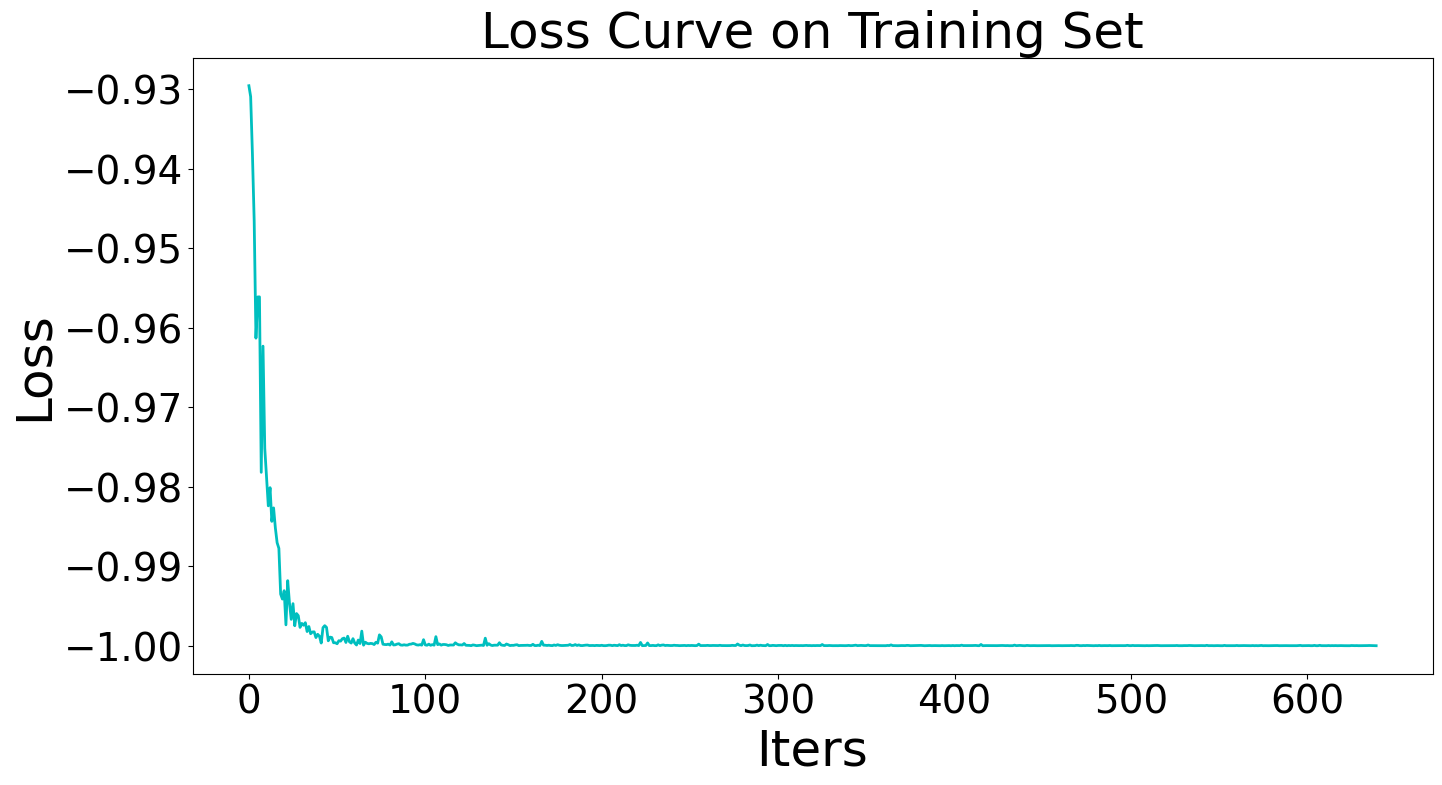

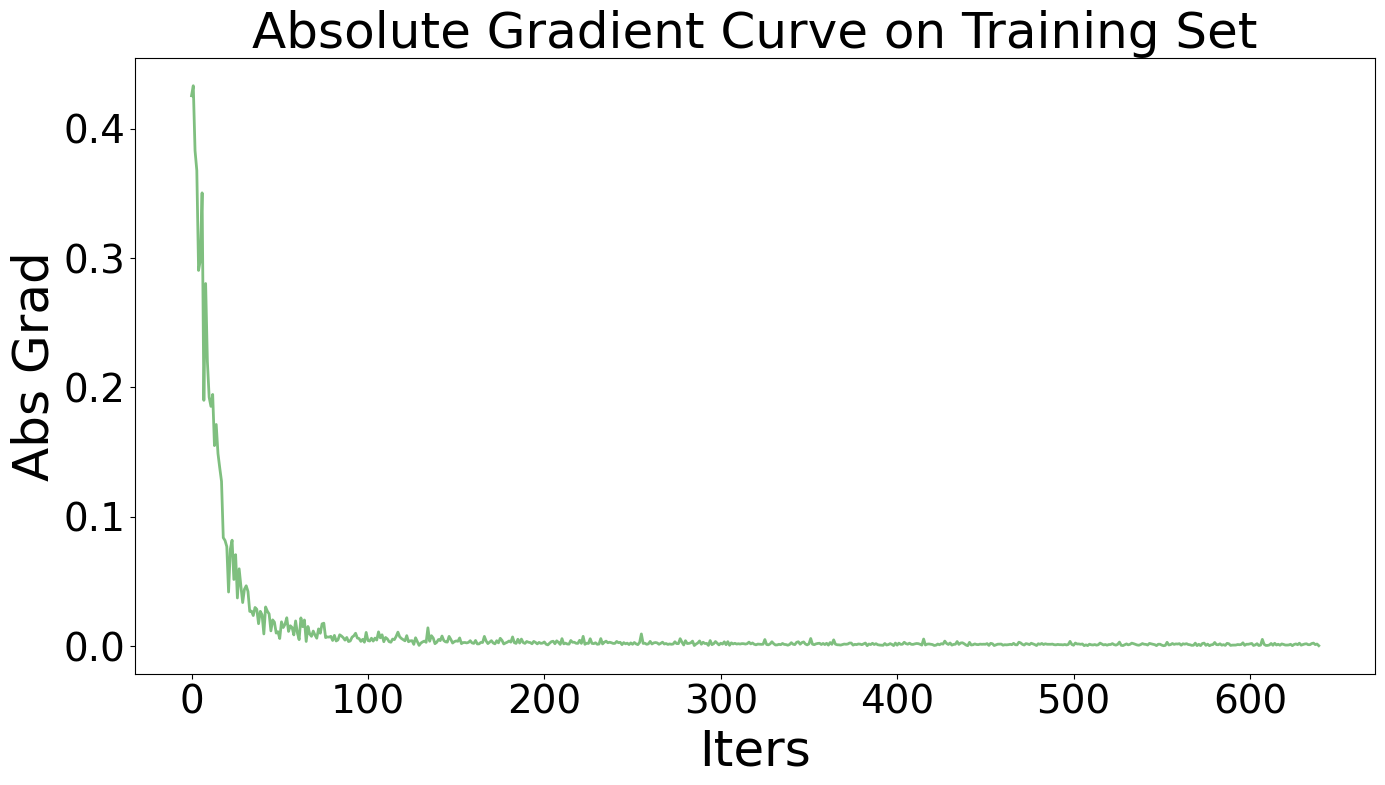

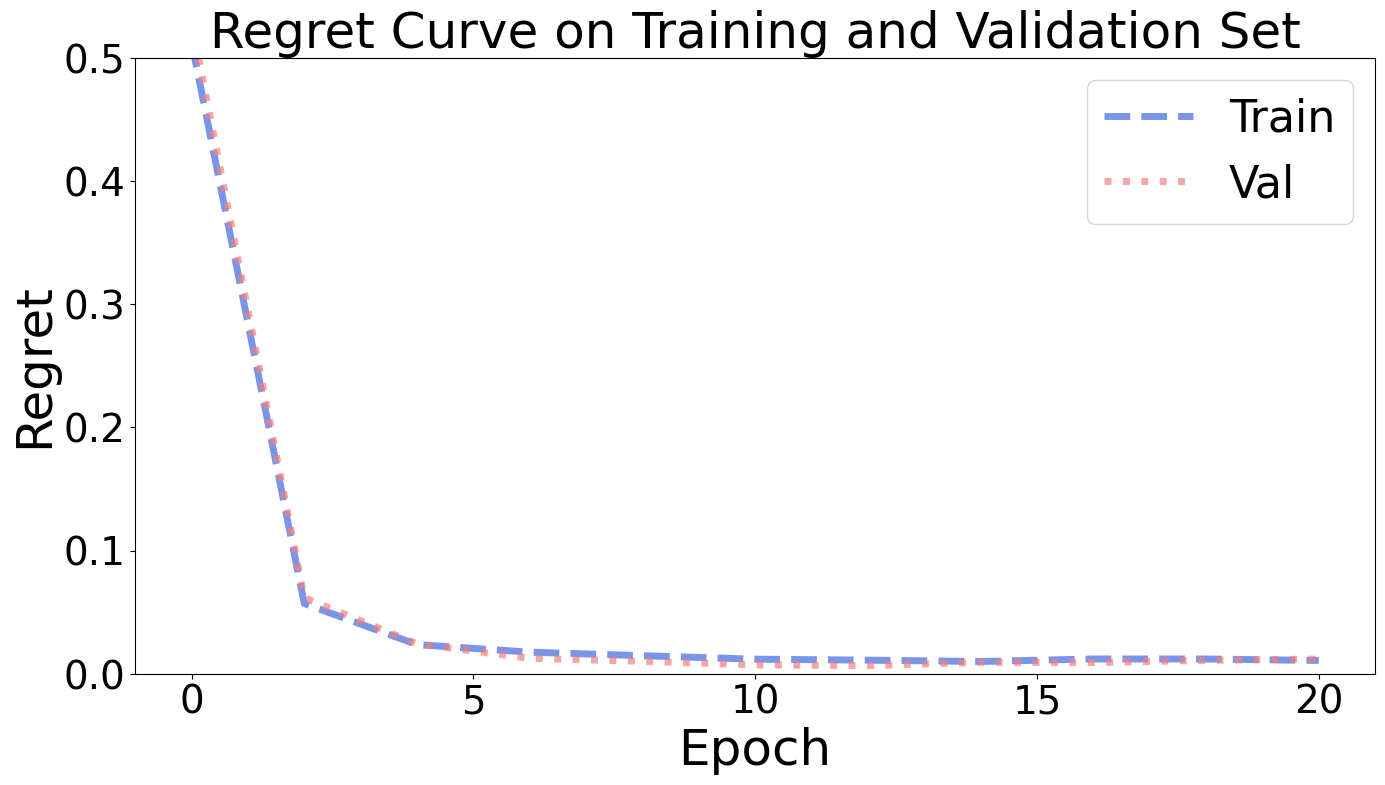

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Vector Method

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import avgConeAlignedCosine

# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [18]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  43.9374%, Val Regret:  41.3425%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:05<00:30,  1.72s/it]

Epoch   2, Train Regret:   3.2641%, Val Regret:   3.0294%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:08<00:27,  1.71s/it]

Epoch   4, Train Regret:   2.7021%, Val Regret:   2.9793%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:12<00:23,  1.69s/it]

Epoch   6, Train Regret:   2.7264%, Val Regret:   2.9694%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [00:16<00:20,  1.71s/it]

Epoch   8, Train Regret:   2.5527%, Val Regret:   3.0064%


Epoch    9, Loss:  -0.9999:  50%|███████████████████████████                           | 10/20 [00:19<00:16,  1.69s/it]

Epoch  10, Train Regret:   2.6968%, Val Regret:   2.9644%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [00:23<00:13,  1.68s/it]

Epoch  12, Train Regret:   2.7273%, Val Regret:   3.0883%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [00:27<00:10,  1.72s/it]

Epoch  14, Train Regret:   2.4977%, Val Regret:   2.8708%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [00:30<00:06,  1.72s/it]

Epoch  16, Train Regret:   2.6166%, Val Regret:   2.8314%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [00:34<00:03,  1.69s/it]

Epoch  18, Train Regret:   2.7125%, Val Regret:   3.0158%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.83s/it]


Epoch  19, Train Regret:   2.4545%, Val Regret:   3.0656%

Evaluation:
Test Regret: 2.9807%
Training Elapsed Time: 1.84 Sec


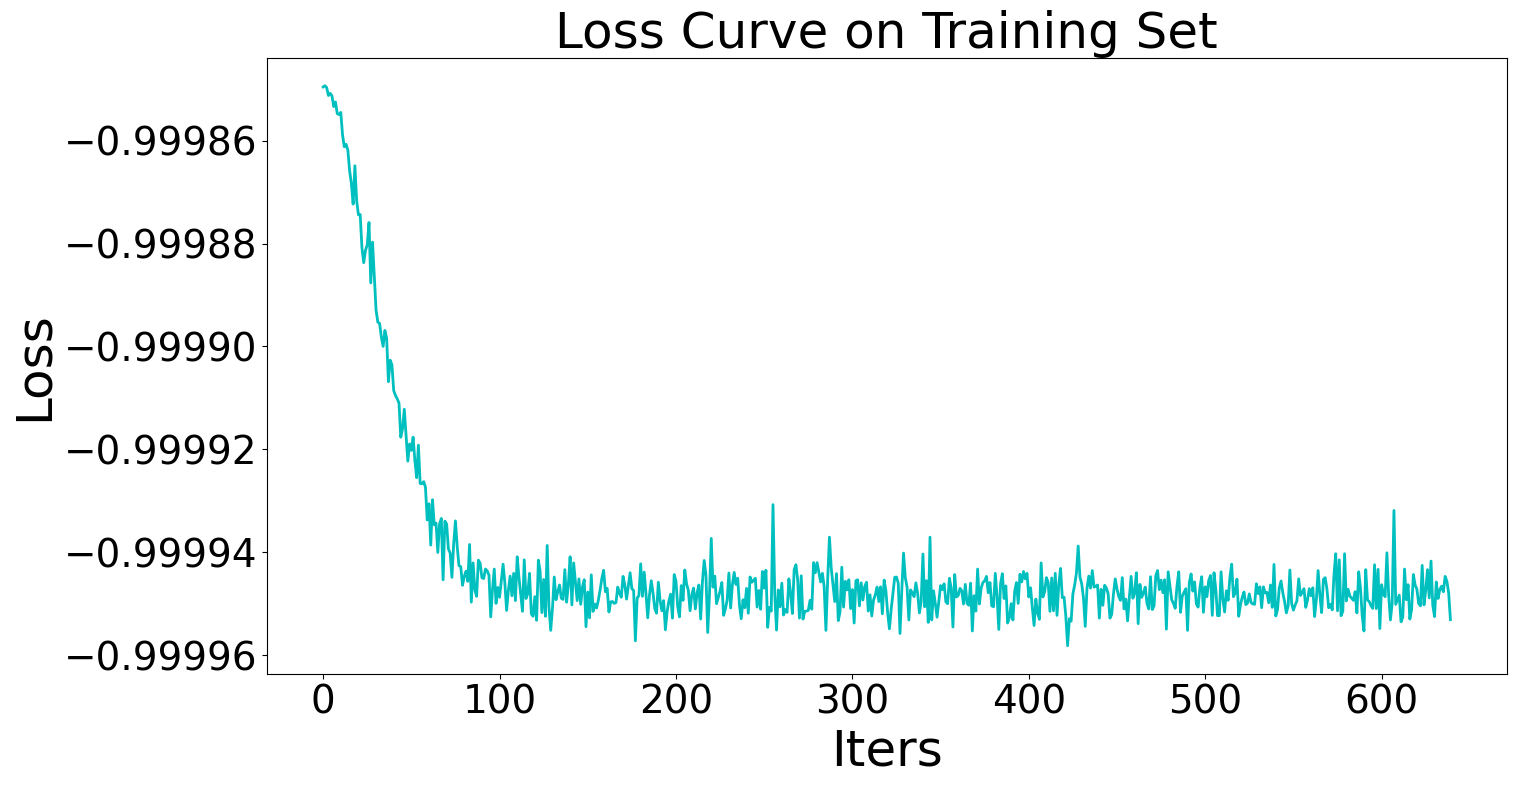

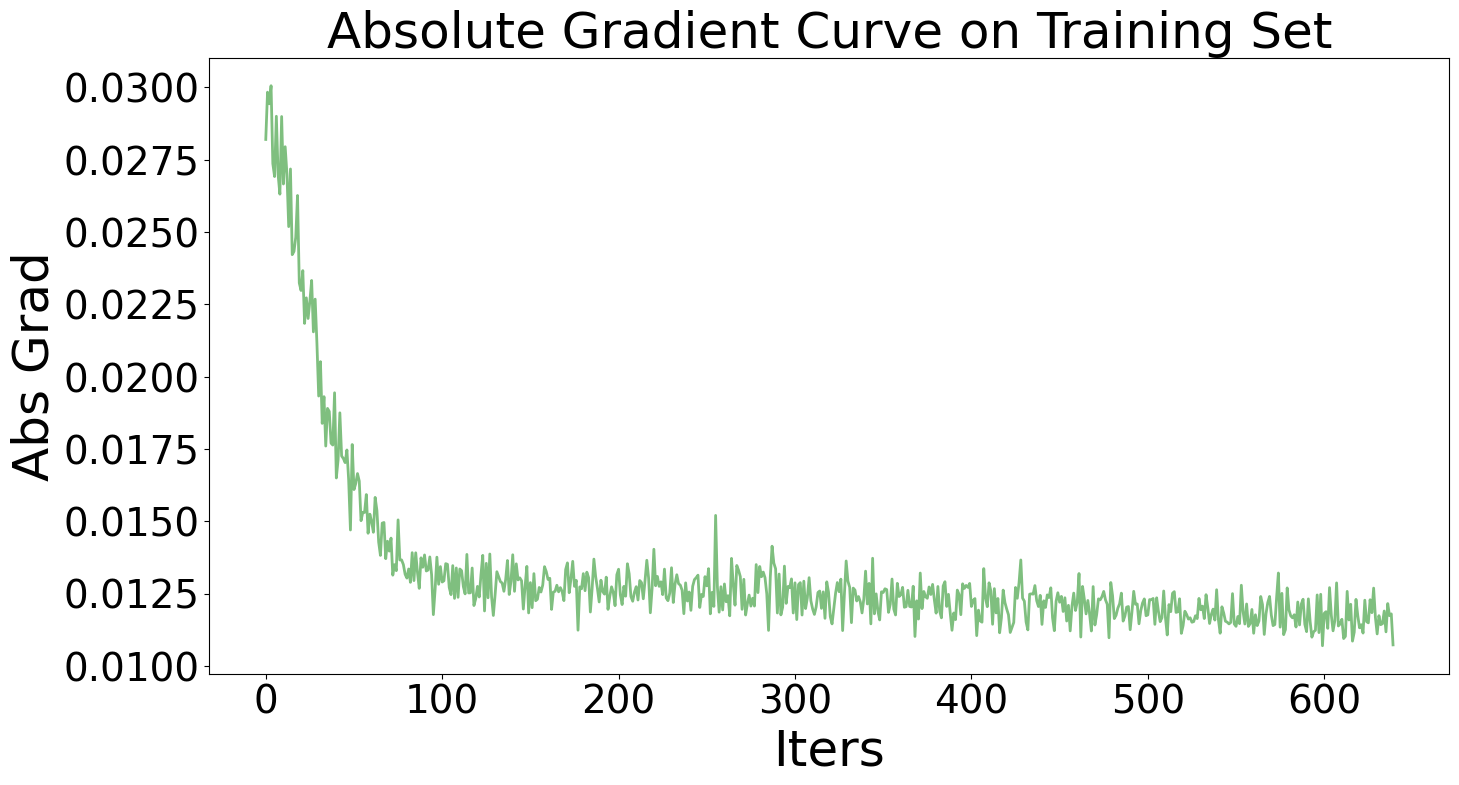

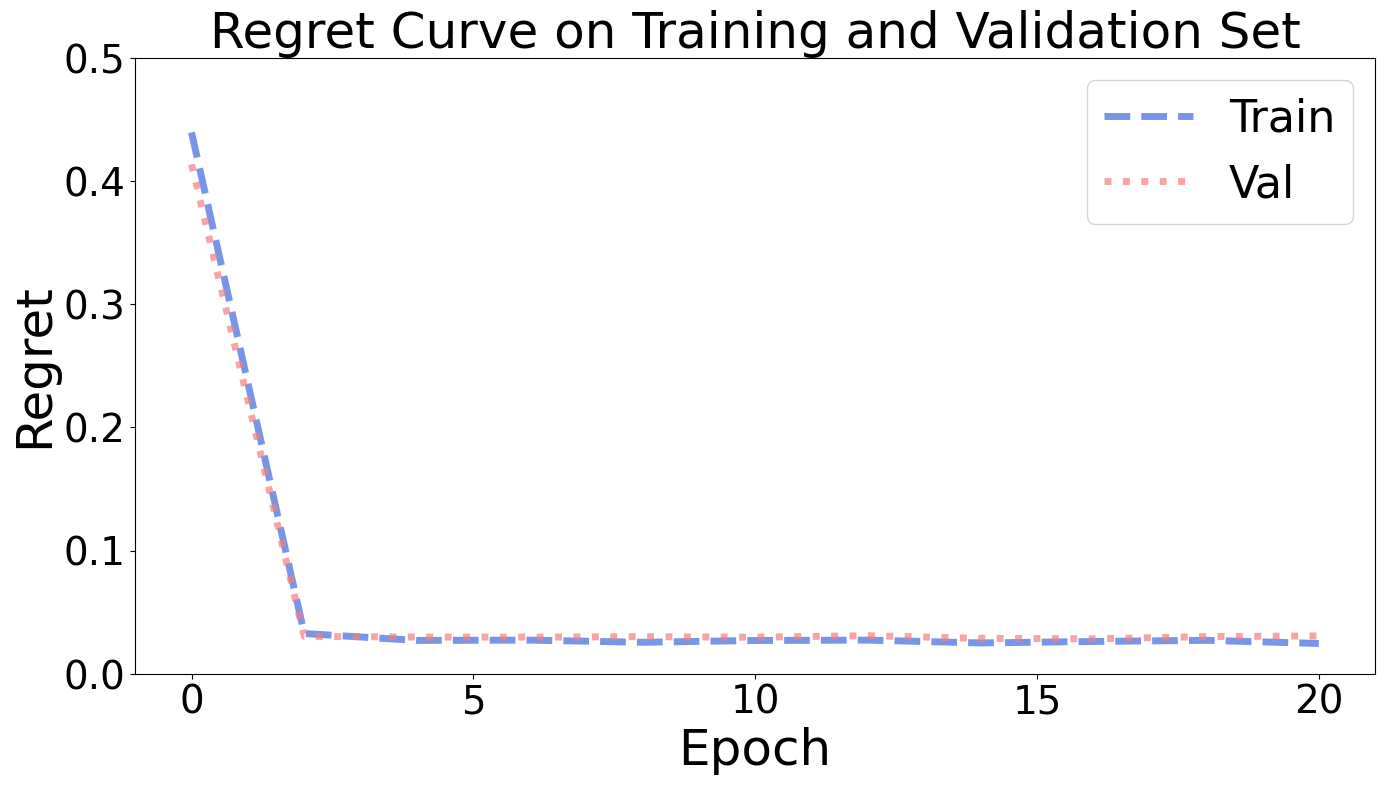

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [22]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  43.9374%, Val Regret:  41.3425%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:05<00:32,  1.82s/it]

Epoch   2, Train Regret:   3.3147%, Val Regret:   3.3776%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:09<00:29,  1.85s/it]

Epoch   4, Train Regret:   2.5967%, Val Regret:   2.6240%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:13<00:25,  1.84s/it]

Epoch   6, Train Regret:   2.7371%, Val Regret:   3.0789%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [00:17<00:21,  1.83s/it]

Epoch   8, Train Regret:   2.5638%, Val Regret:   3.0829%


Epoch    9, Loss:  -0.9999:  50%|███████████████████████████                           | 10/20 [00:21<00:18,  1.84s/it]

Epoch  10, Train Regret:   2.6033%, Val Regret:   2.9653%


Epoch   11, Loss:  -0.9999:  60%|████████████████████████████████▍                     | 12/20 [00:25<00:15,  1.88s/it]

Epoch  12, Train Regret:   2.5775%, Val Regret:   2.8557%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████▊                | 14/20 [00:29<00:11,  1.90s/it]

Epoch  14, Train Regret:   2.5122%, Val Regret:   2.6977%


Epoch   15, Loss:  -0.9999:  80%|███████████████████████████████████████████▏          | 16/20 [00:33<00:07,  1.89s/it]

Epoch  16, Train Regret:   2.4134%, Val Regret:   2.9136%


Epoch   17, Loss:  -0.9999:  90%|████████████████████████████████████████████████▌     | 18/20 [00:37<00:03,  1.89s/it]

Epoch  18, Train Regret:   2.6271%, Val Regret:   2.9305%


Epoch   19, Loss:  -0.9999: 100%|██████████████████████████████████████████████████████| 20/20 [00:39<00:00,  2.00s/it]


Epoch  19, Train Regret:   2.2376%, Val Regret:   2.8824%

Evaluation:
Test Regret: 2.7689%
Training Elapsed Time: 4.04 Sec


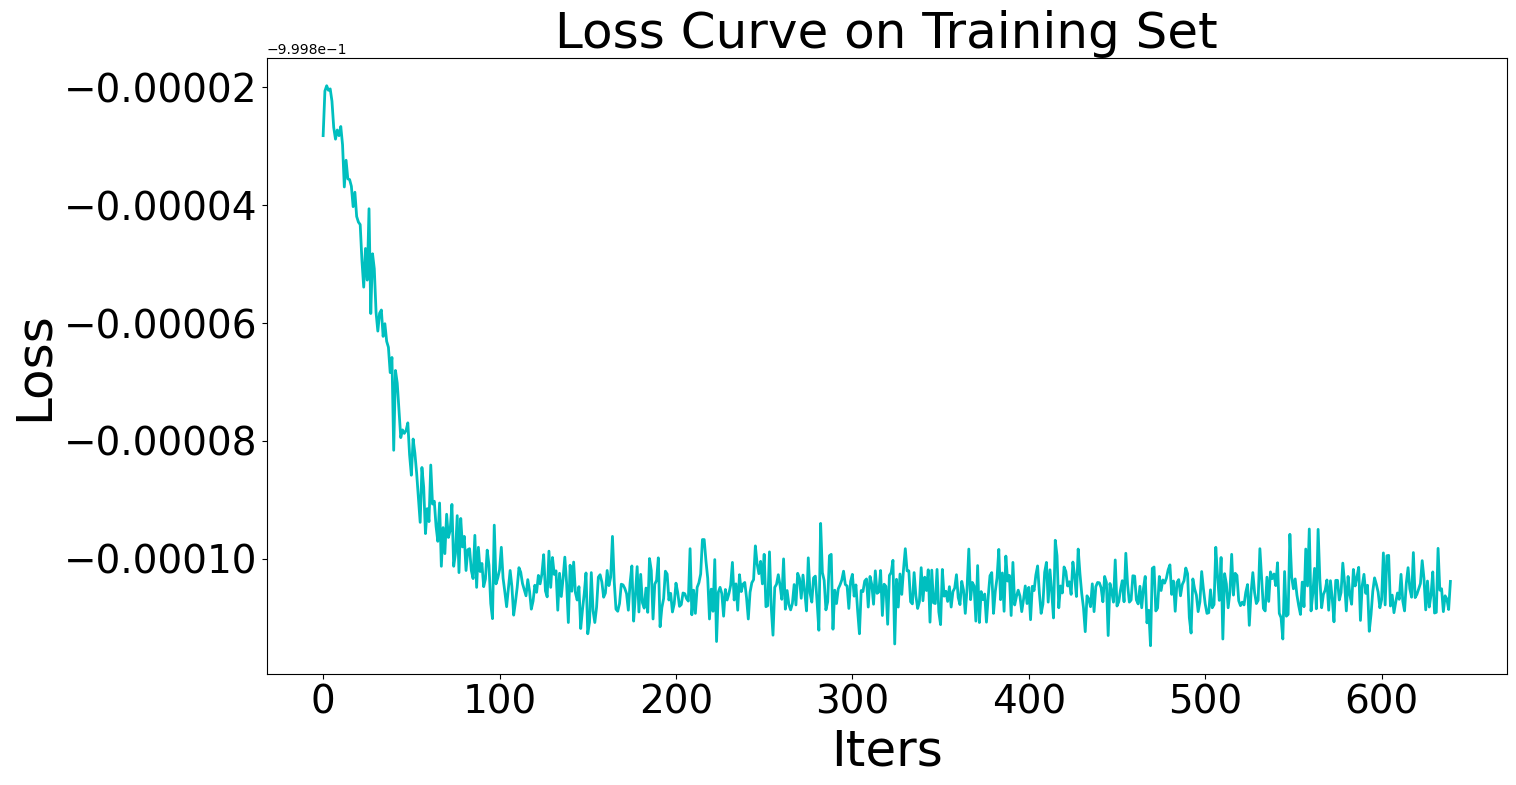

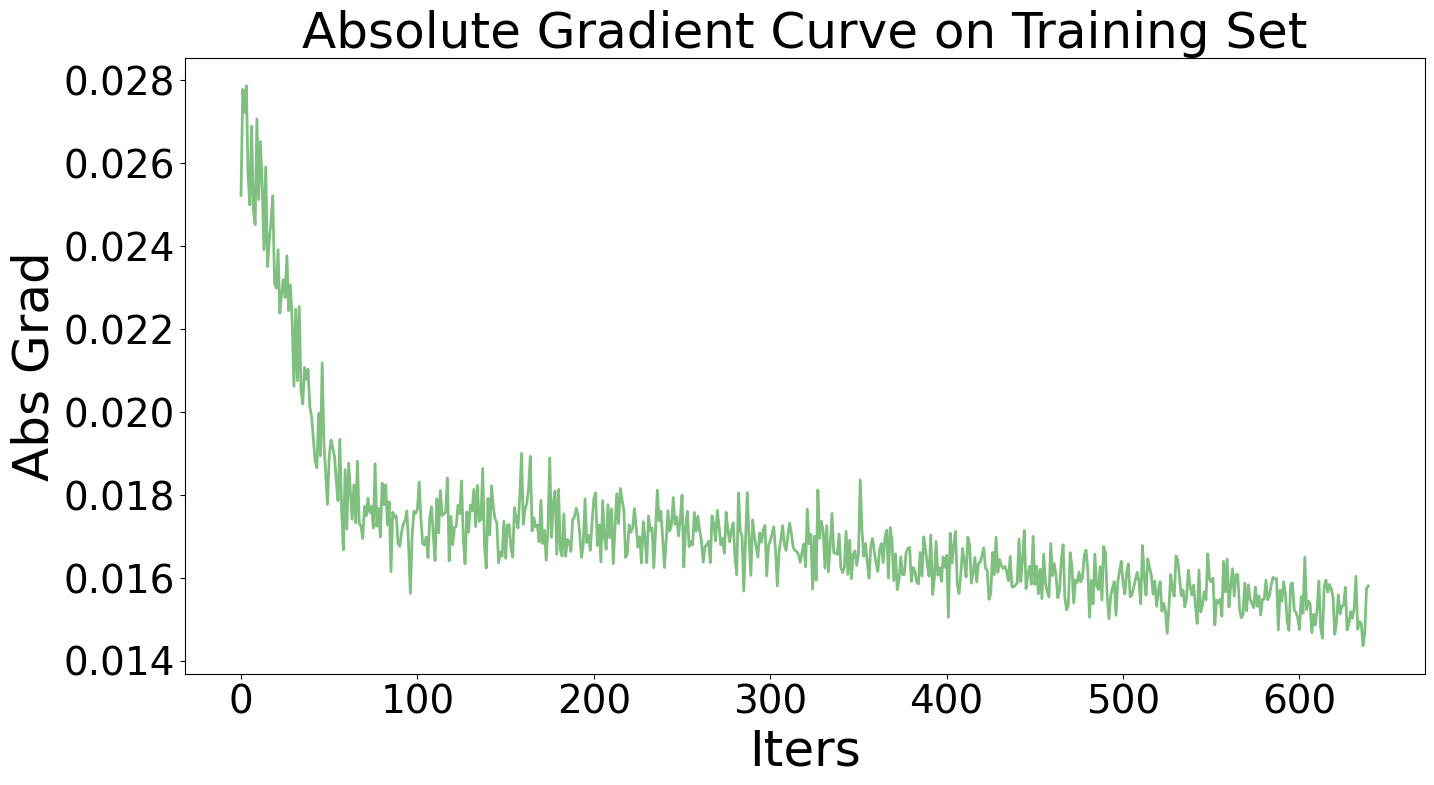

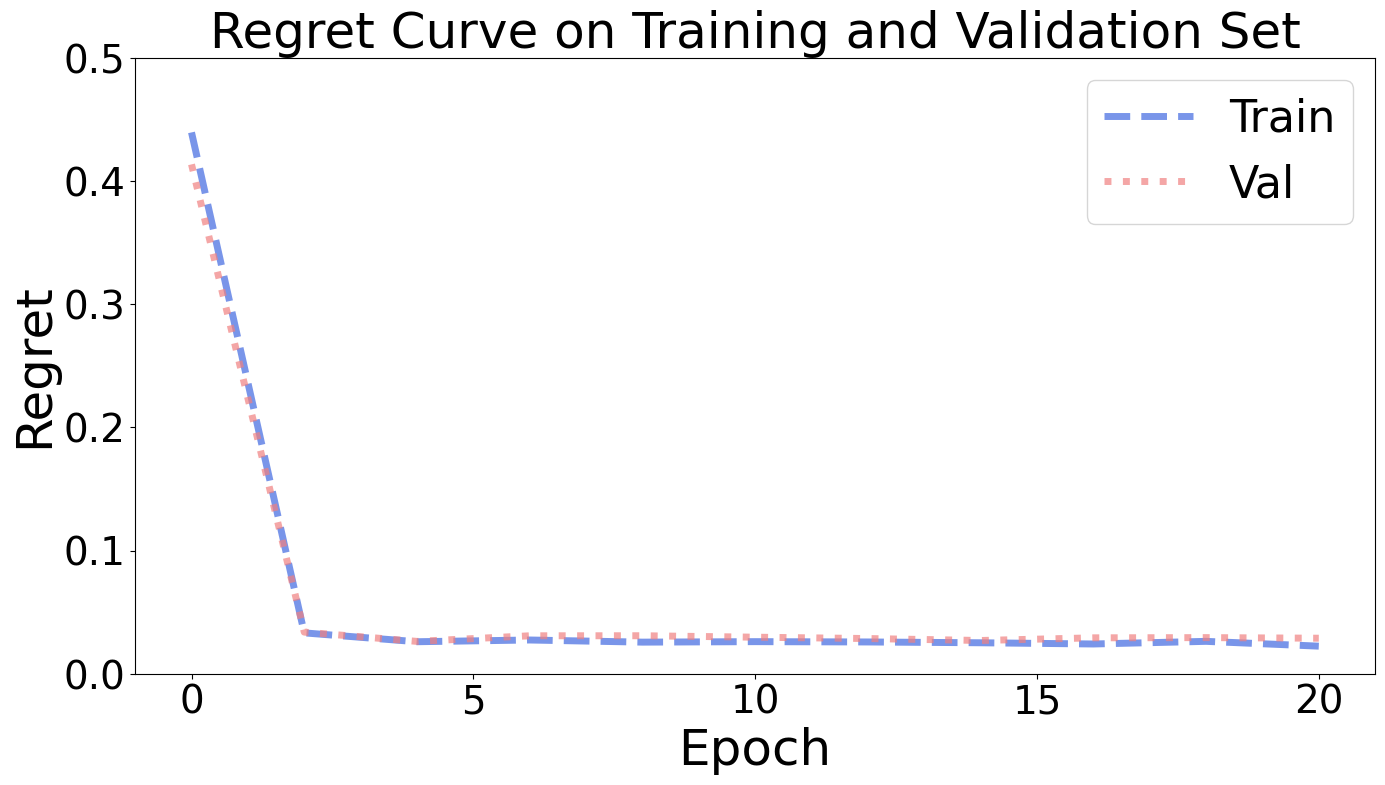

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

Num of cores: 1


In [26]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  50.7620%, Val Regret:  57.3159%


Epoch    1, Loss:  -0.9991:  10%|█████▌                                                 | 2/20 [00:05<00:30,  1.72s/it]

Epoch   2, Train Regret:   8.1550%, Val Regret:  10.0651%


Epoch    3, Loss:  -0.9996:  20%|███████████                                            | 4/20 [00:08<00:27,  1.71s/it]

Epoch   4, Train Regret:   4.1103%, Val Regret:   2.7741%


Epoch    5, Loss:  -0.9998:  30%|████████████████▌                                      | 6/20 [00:12<00:23,  1.70s/it]

Epoch   6, Train Regret:   3.3206%, Val Regret:   2.2723%


Epoch    7, Loss:  -0.9996:  40%|██████████████████████                                 | 8/20 [00:15<00:20,  1.68s/it]

Epoch   8, Train Regret:   3.0490%, Val Regret:   2.1451%


Epoch    9, Loss:  -0.9998:  50%|███████████████████████████                           | 10/20 [00:19<00:16,  1.67s/it]

Epoch  10, Train Regret:   3.1201%, Val Regret:   1.9423%


Epoch   11, Loss:  -0.9999:  60%|████████████████████████████████▍                     | 12/20 [00:23<00:13,  1.69s/it]

Epoch  12, Train Regret:   3.0938%, Val Regret:   2.0210%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [00:27<00:10,  1.71s/it]

Epoch  14, Train Regret:   3.3854%, Val Regret:   2.1399%


Epoch   15, Loss:  -0.9998:  80%|███████████████████████████████████████████▏          | 16/20 [00:30<00:06,  1.71s/it]

Epoch  16, Train Regret:   3.5007%, Val Regret:   2.4635%


Epoch   17, Loss:  -0.9999:  90%|████████████████████████████████████████████████▌     | 18/20 [00:34<00:03,  1.71s/it]

Epoch  18, Train Regret:   3.9144%, Val Regret:   3.5098%


Epoch   19, Loss:  -0.9999: 100%|██████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.83s/it]


Epoch  19, Train Regret:   4.6547%, Val Regret:   5.4138%

Evaluation:
Test Regret: 5.1562%
Training Elapsed Time: 1.80 Sec


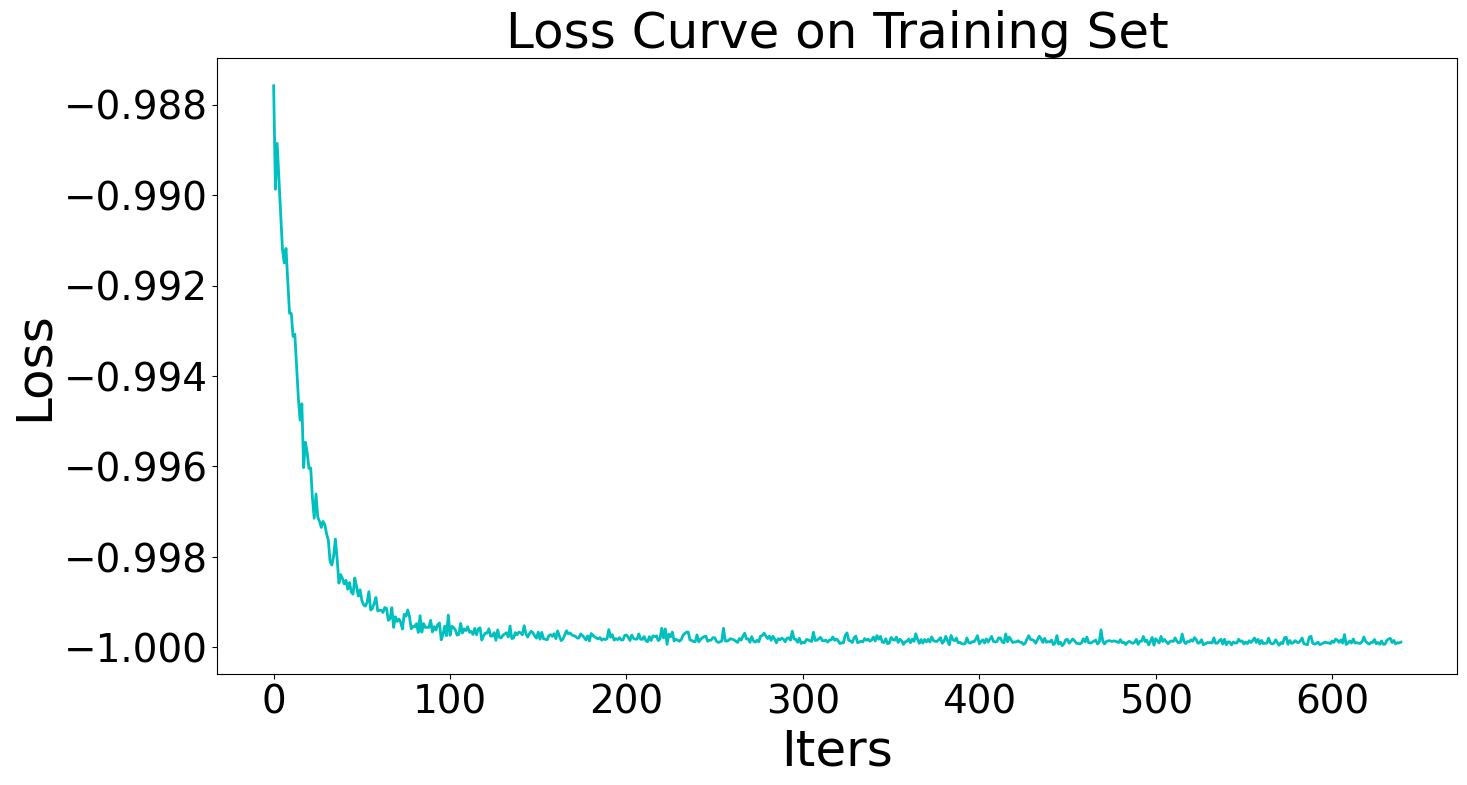

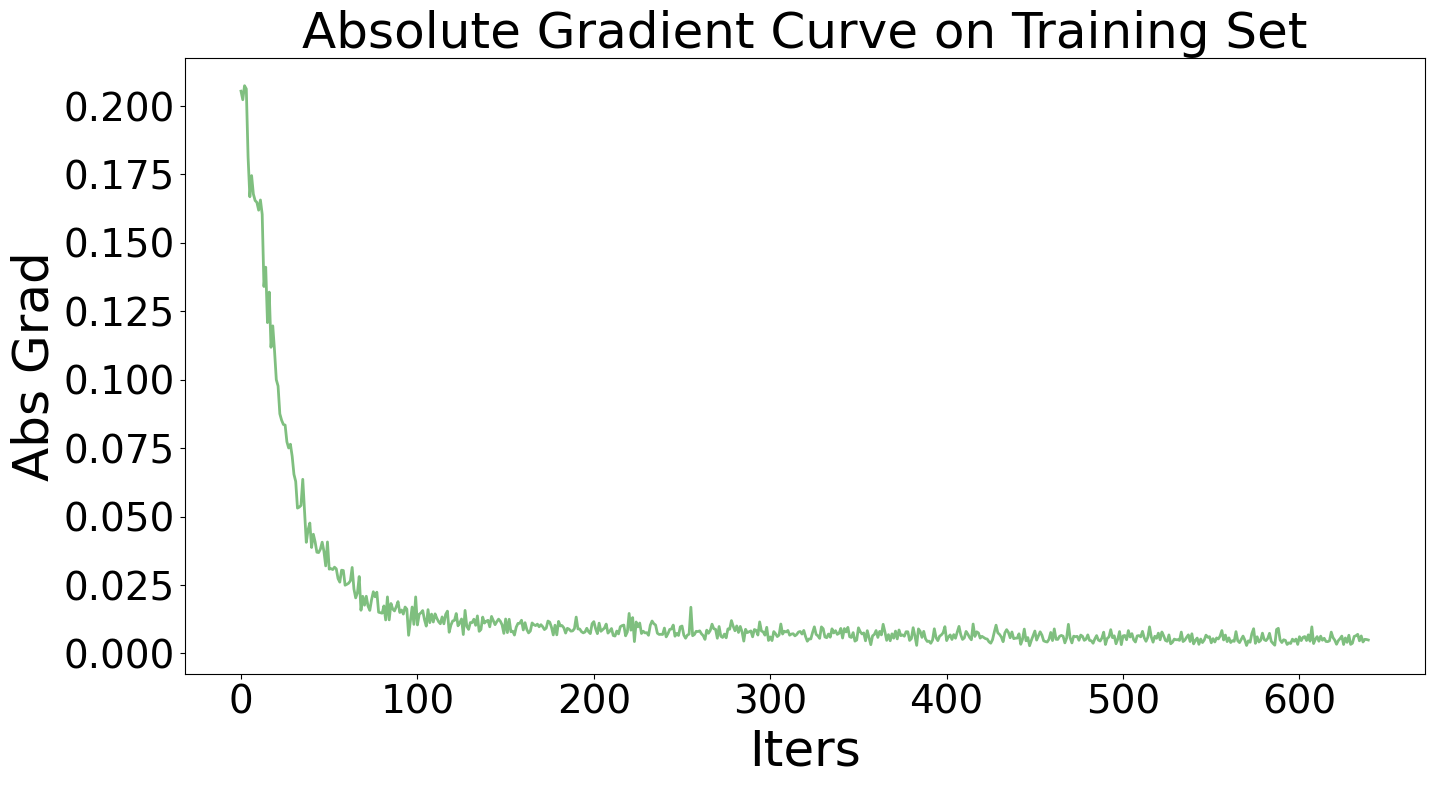

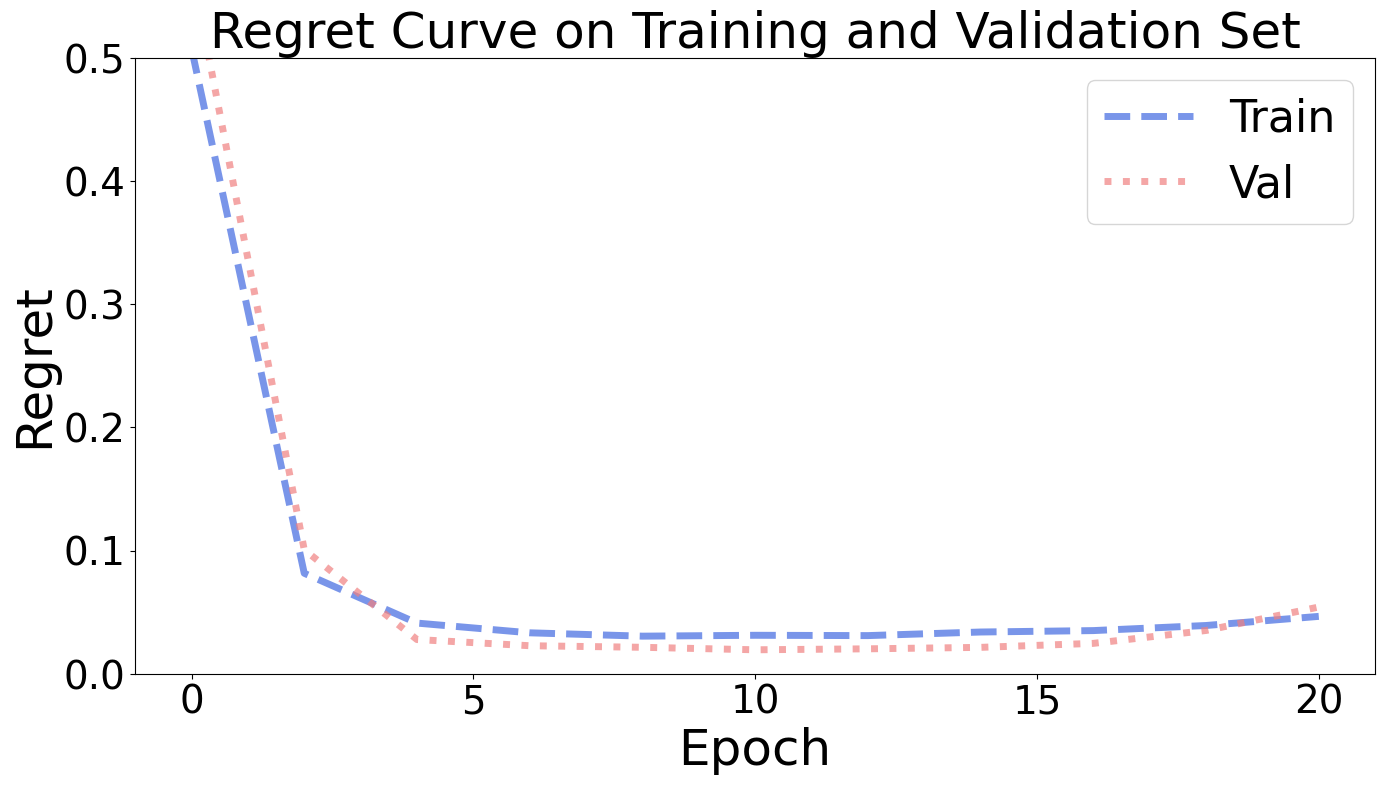

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [30]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  43.9374%, Val Regret:  41.3425%


Epoch    1, Loss:  -0.9966:  10%|█████▌                                                 | 2/20 [00:05<00:36,  2.03s/it]

Epoch   2, Train Regret:   1.9011%, Val Regret:   1.9288%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:10<00:32,  2.04s/it]

Epoch   4, Train Regret:   1.2245%, Val Regret:   1.6227%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:14<00:28,  2.02s/it]

Epoch   6, Train Regret:   0.9250%, Val Regret:   0.9990%


Epoch    7, Loss:  -0.9989:  40%|██████████████████████                                 | 8/20 [00:18<00:24,  2.01s/it]

Epoch   8, Train Regret:   0.9148%, Val Regret:   1.0984%


Epoch    9, Loss:  -0.9998:  50%|███████████████████████████                           | 10/20 [00:22<00:20,  2.00s/it]

Epoch  10, Train Regret:   0.7828%, Val Regret:   0.8290%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [00:27<00:15,  1.99s/it]

Epoch  12, Train Regret:   0.8097%, Val Regret:   0.9392%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████▊                | 14/20 [00:31<00:11,  1.99s/it]

Epoch  14, Train Regret:   0.7772%, Val Regret:   0.7338%


Epoch   15, Loss:  -0.9999:  80%|███████████████████████████████████████████▏          | 16/20 [00:35<00:08,  2.01s/it]

Epoch  16, Train Regret:   0.7269%, Val Regret:   0.7183%


Epoch   17, Loss:  -0.9998:  90%|████████████████████████████████████████████████▌     | 18/20 [00:39<00:03,  1.98s/it]

Epoch  18, Train Regret:   0.7447%, Val Regret:   0.6894%


Epoch   19, Loss:  -0.9999: 100%|██████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.14s/it]


Epoch  19, Train Regret:   0.7217%, Val Regret:   0.6849%

Evaluation:
Test Regret: 0.6817%
Training Elapsed Time: 7.66 Sec


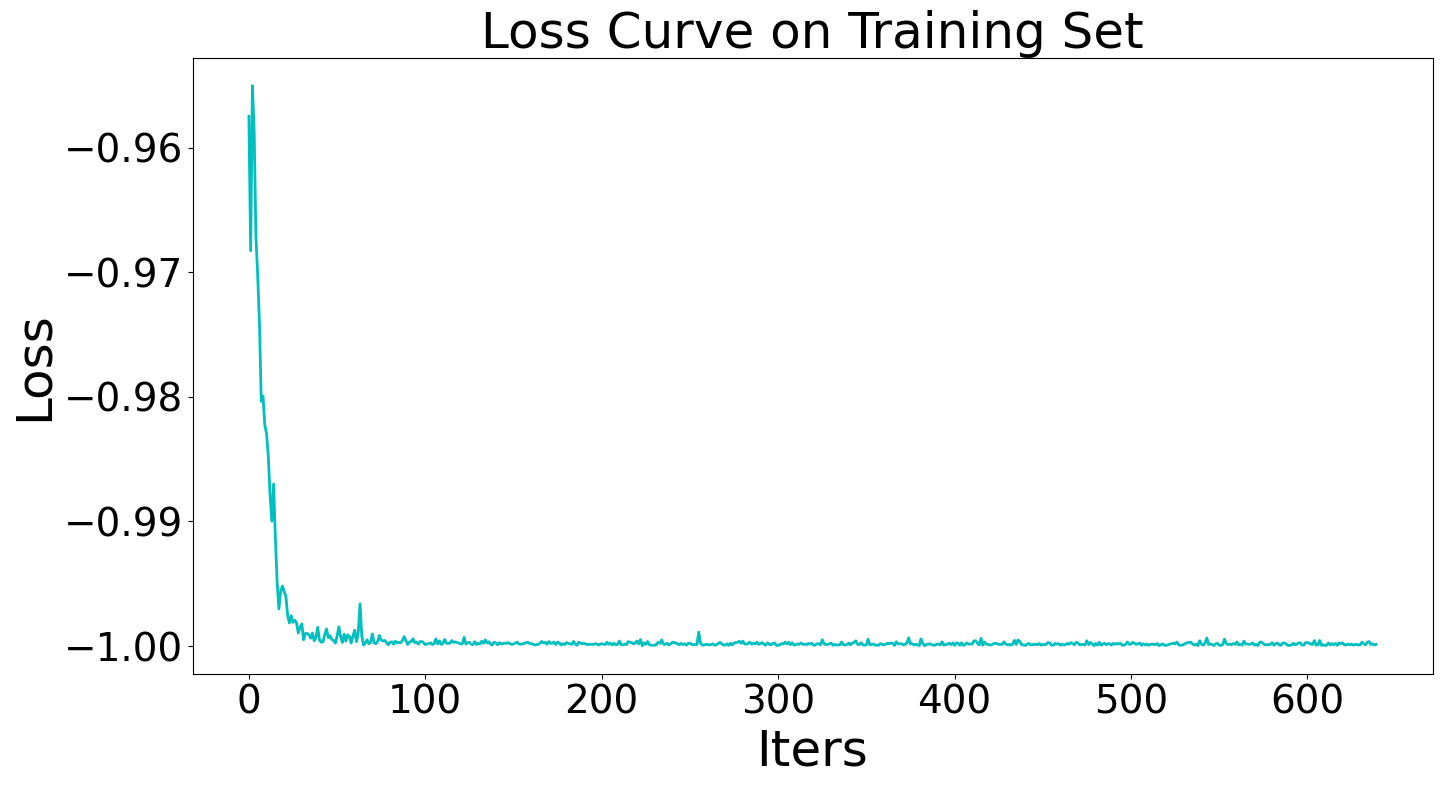

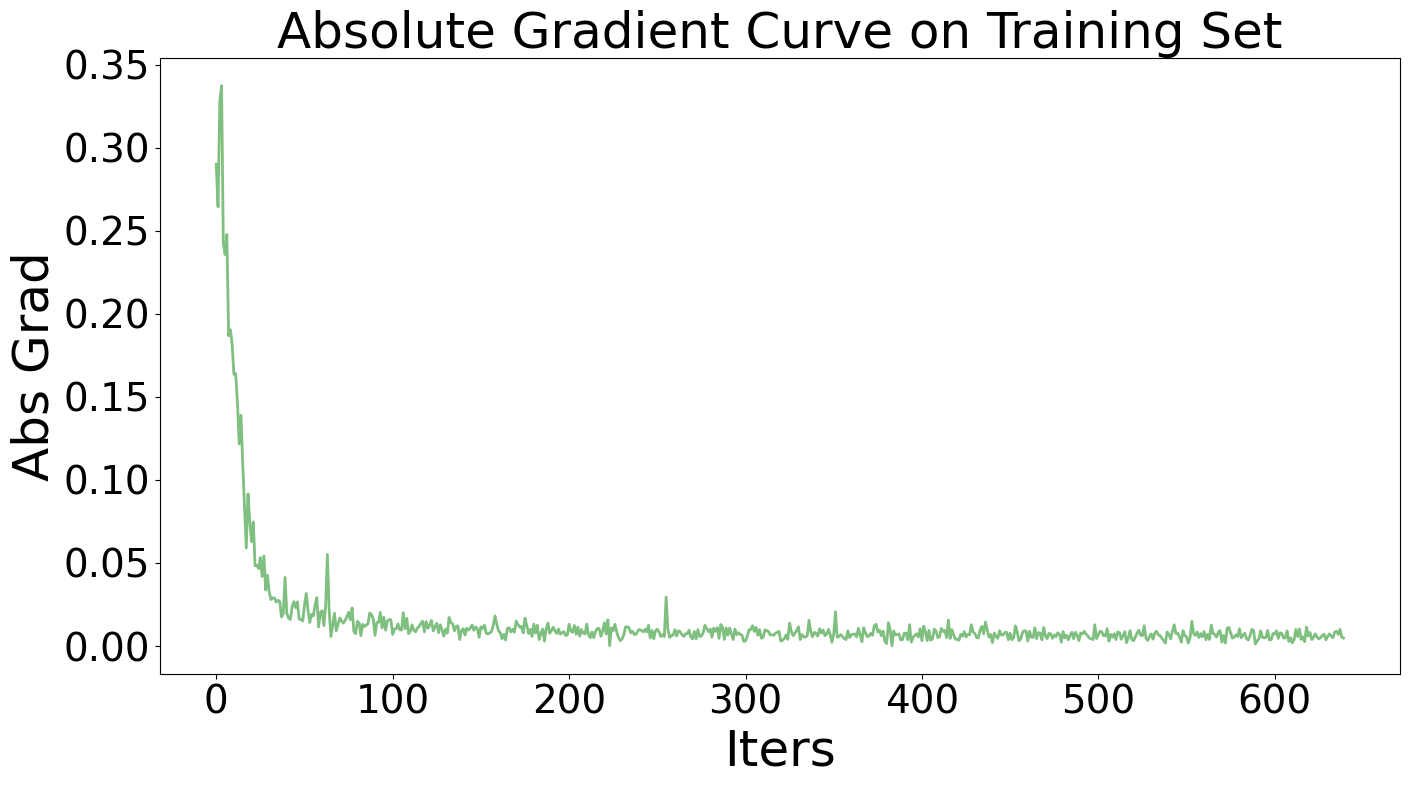

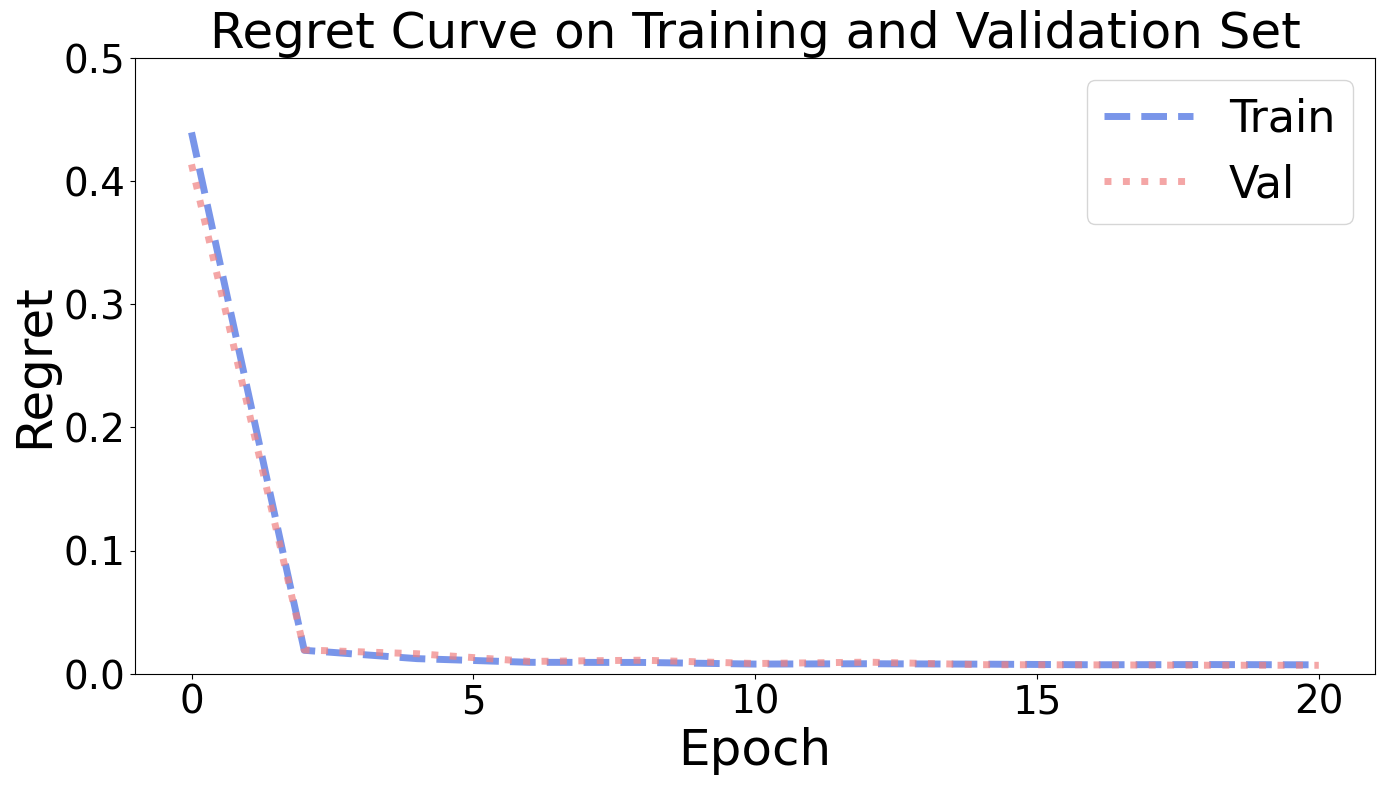

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner & Average Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", solve_ratio=0.1, processes=1)

Num of cores: 1


In [34]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  43.9374%, Val Regret:  41.3425%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:05<00:30,  1.69s/it]

Epoch   2, Train Regret:   5.9920%, Val Regret:   8.1984%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:08<00:27,  1.72s/it]

Epoch   4, Train Regret:   2.3211%, Val Regret:   3.7718%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:12<00:24,  1.75s/it]

Epoch   6, Train Regret:   2.0990%, Val Regret:   2.7803%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [00:16<00:21,  1.77s/it]

Epoch   8, Train Regret:   1.9116%, Val Regret:   2.6427%


Epoch    9, Loss:  -0.9999:  50%|███████████████████████████                           | 10/20 [00:20<00:18,  1.82s/it]

Epoch  10, Train Regret:   1.6185%, Val Regret:   1.6634%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [00:24<00:14,  1.83s/it]

Epoch  12, Train Regret:   1.7149%, Val Regret:   1.9852%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████▊                | 14/20 [00:28<00:10,  1.79s/it]

Epoch  14, Train Regret:   1.7818%, Val Regret:   2.1438%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [00:31<00:07,  1.75s/it]

Epoch  16, Train Regret:   1.8097%, Val Regret:   2.4121%


Epoch   17, Loss:  -0.9999:  90%|████████████████████████████████████████████████▌     | 18/20 [00:35<00:03,  1.73s/it]

Epoch  18, Train Regret:   2.1780%, Val Regret:   2.3463%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.90s/it]


Epoch  19, Train Regret:   1.7493%, Val Regret:   2.4810%

Evaluation:
Test Regret: 2.1211%
Training Elapsed Time: 2.59 Sec


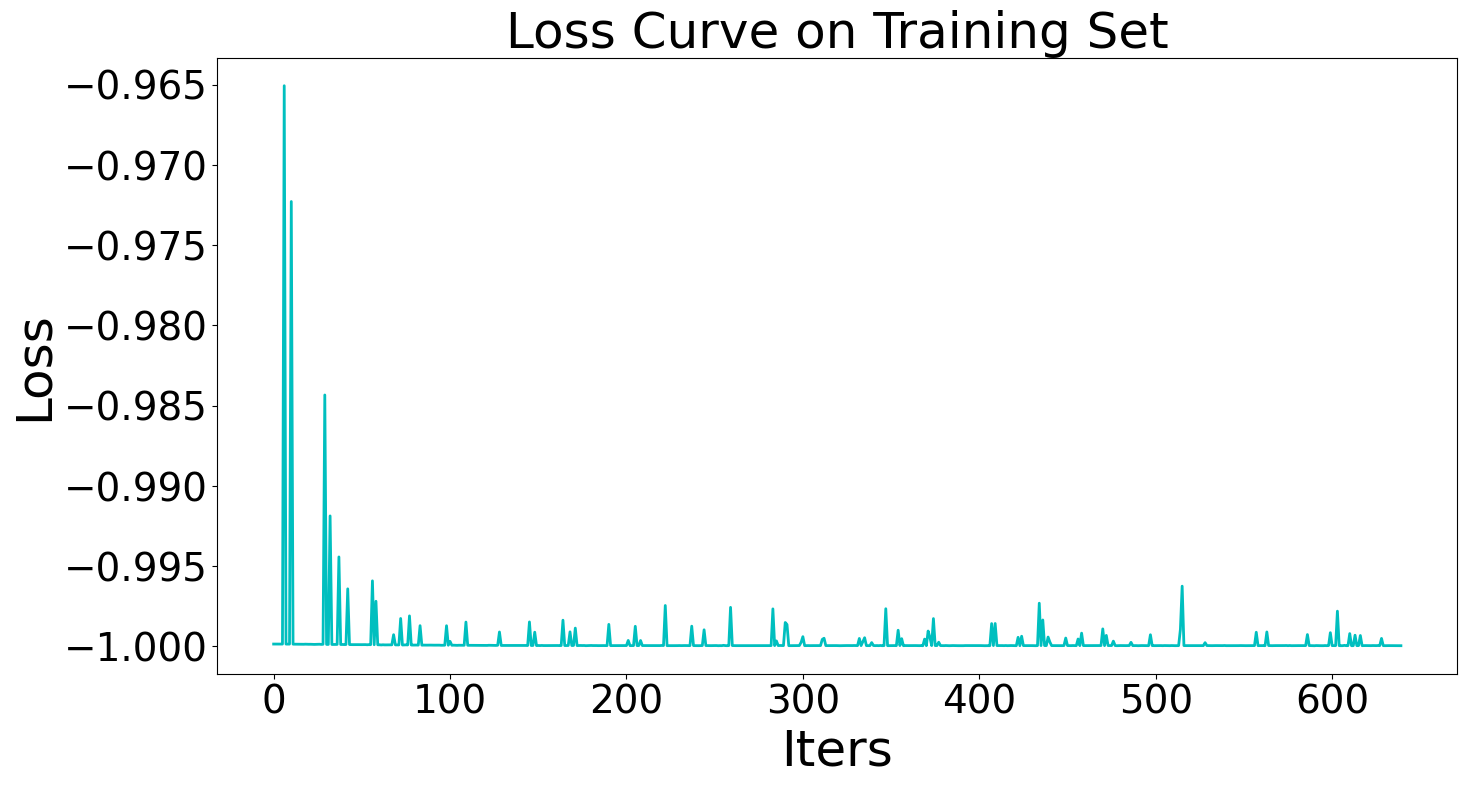

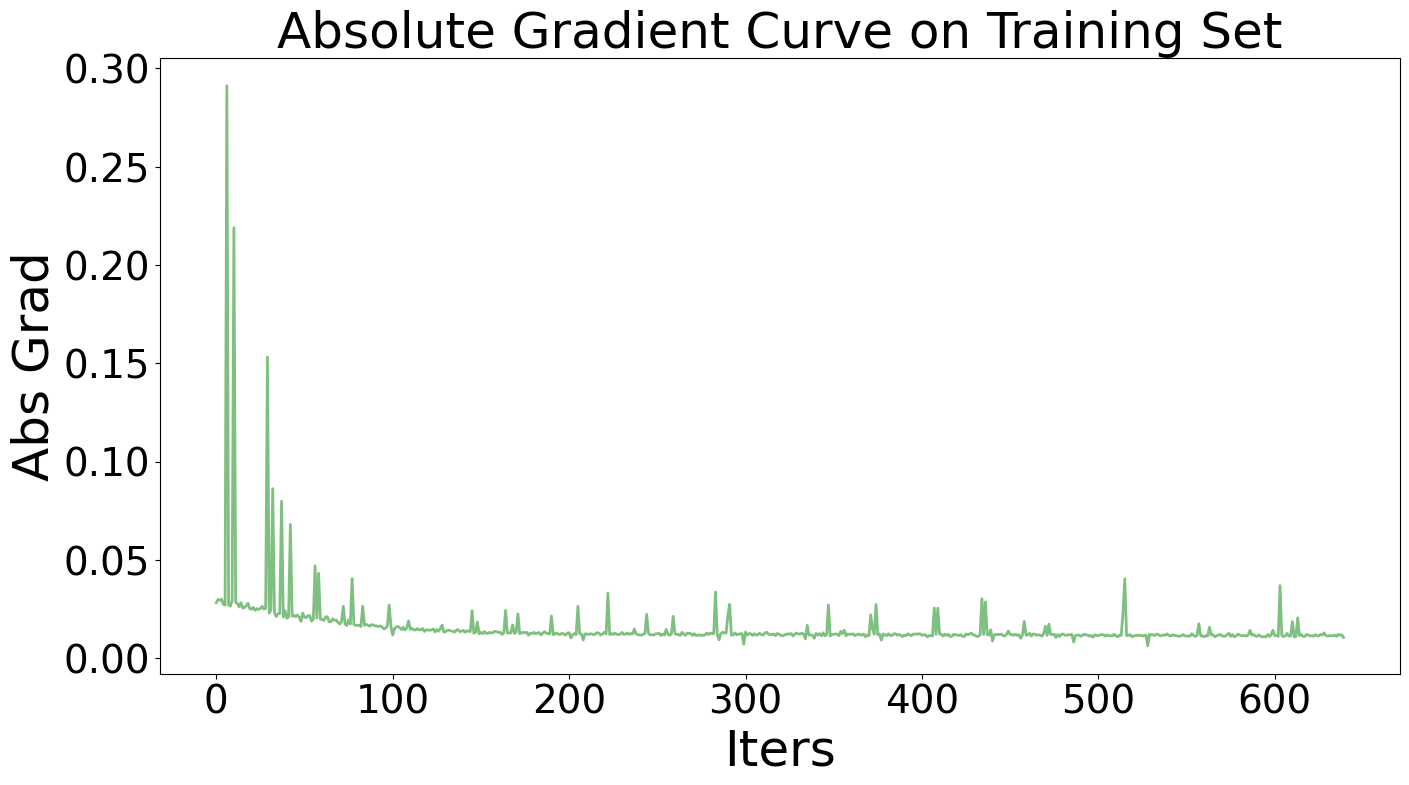

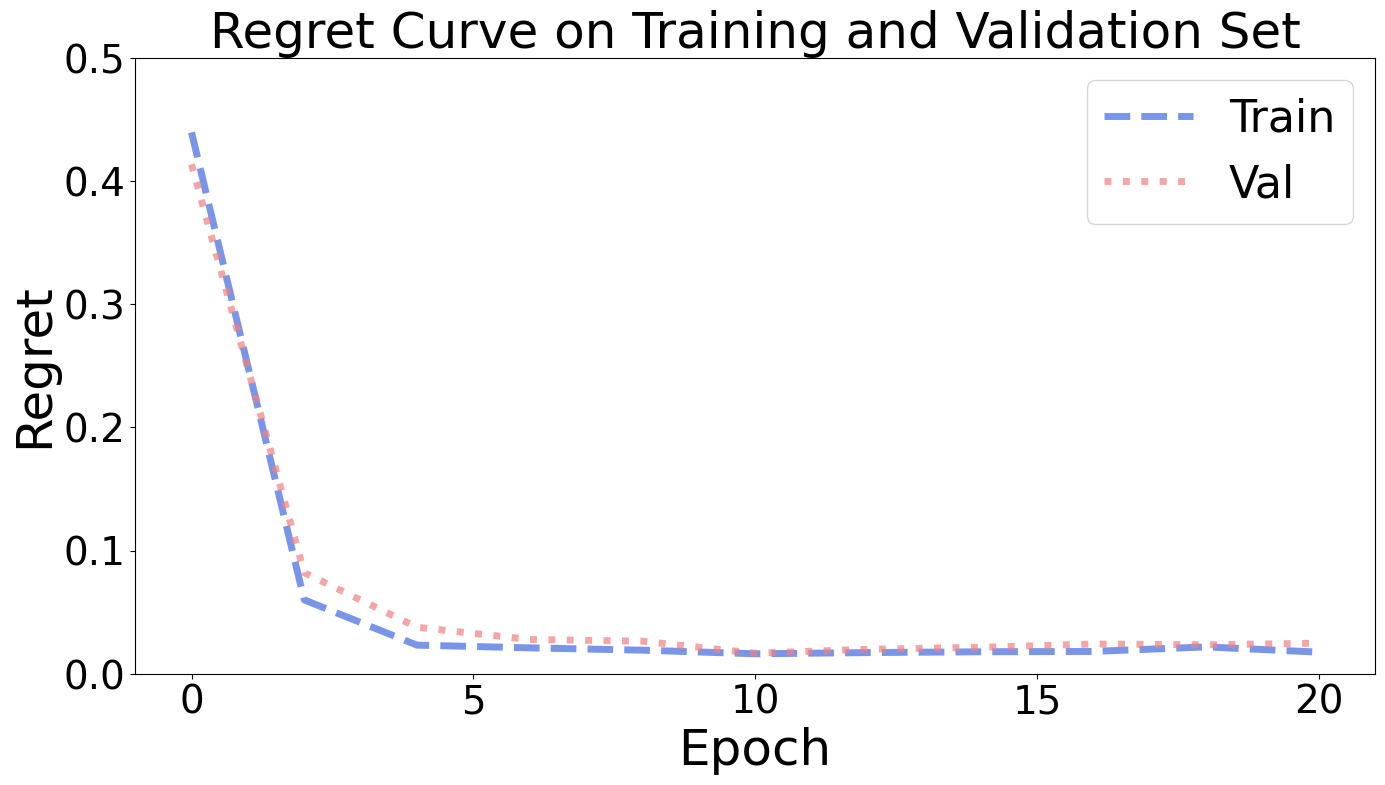

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)